In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
train_data = np.load('CIFAKE_Train.npz')
test_data = np.load('CIFAKE_Test.npz')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_data['images'], train_data['labels'], test_size=0.2, random_state=42)

In [ ]:
x_test = test_data['images']
y_test = test_data['labels']

In [ ]:
def create_custom_model(num_conv_layers, num_dense_layers, num_neurons):
    model = Sequential()

    # Add convolutional layers
    for _ in range(num_conv_layers):
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Add dense layers
    for _ in range(num_dense_layers):
        model.add(Dense(num_neurons, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Define hyperparameter variations
num_conv_layers_list = [1, 2]
num_dense_layers_list = [1, 2, 4]
num_neurons_list = [128, 256, 512]
epochs = 2
batch_size = 64
validation_split = 0.2

# Lists to store results
val_accuracies = []
test_accuracies = []
labels = []

In [ ]:
# Iterate over hyperparameters
for num_conv_layers in num_conv_layers_list:
    for num_dense_layers in num_dense_layers_list:
        for num_neurons in num_neurons_list:
            # Create and compile the model
            model = create_custom_model(num_conv_layers, num_dense_layers, num_neurons)

            # Train the model on your data (replace with your data loading code)
            model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=validation_split)

            # Evaluate the model on validation data
            val_loss, val_accuracy = model.evaluate(x_val,y_val)
            val_accuracies.append(val_accuracy)

            # Evaluate the model on test data
            test_loss, test_accuracy = model.evaluate(x_test,y_test)
            test_accuracies.append(test_accuracy)

            # Create a label for this combination of hyperparameters
            label = f"ConvLayers={num_conv_layers}, DenseLayers={num_dense_layers}, Neurons={num_neurons}"
            labels.append(label)

2023-11-02 17:07:40.974618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22834 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Epoch 1/2


2023-11-02 17:07:41.935848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-11-02 17:07:42.034528: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 17:07:42.181794: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f13d54c1dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 17:07:42.181826: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2023-11-02 17:07:42.186895: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 17:07:42.263530: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 17:07:42.344068: I ./tensorflow/compiler/jit/device_compiler.h:1

1000/1000 [==============================] - 8s 6ms/step - loss: 1.7808 - accuracy: 0.7882 - val_loss: 0.3296 - val_accuracy: 0.8572
Epoch 2/2
625/625 [==============================] - 2s 4ms/step - loss: 0.3093 - accuracy: 0.8729
Epoch 1/2
1000/1000 [==============================] - 8s 6ms/step - loss: 2.0070 - accuracy: 0.8132 - val_loss: 0.3318 - val_accuracy: 0.8602
Epoch 2/2
625/625 [==============================] - 2s 4ms/step - loss: 0.2994 - accuracy: 0.8745
Epoch 1/2
1000/1000 [==============================] - 8s 6ms/step - loss: 2.4817 - accuracy: 0.7979 - val_loss: 0.3914 - val_accuracy: 0.8386
Epoch 2/2
625/625 [==============================] - 2s 4ms/step - loss: 0.3208 - accuracy: 0.8711
Epoch 1/2
1000/1000 [==============================] - 8s 7ms/step - loss: 0.9596 - accuracy: 0.8169 - val_loss: 0.2918 - val_accuracy: 0.8787
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.2825 - accuracy: 0.8805
Epoch 1/2
1000/1000 [=====================

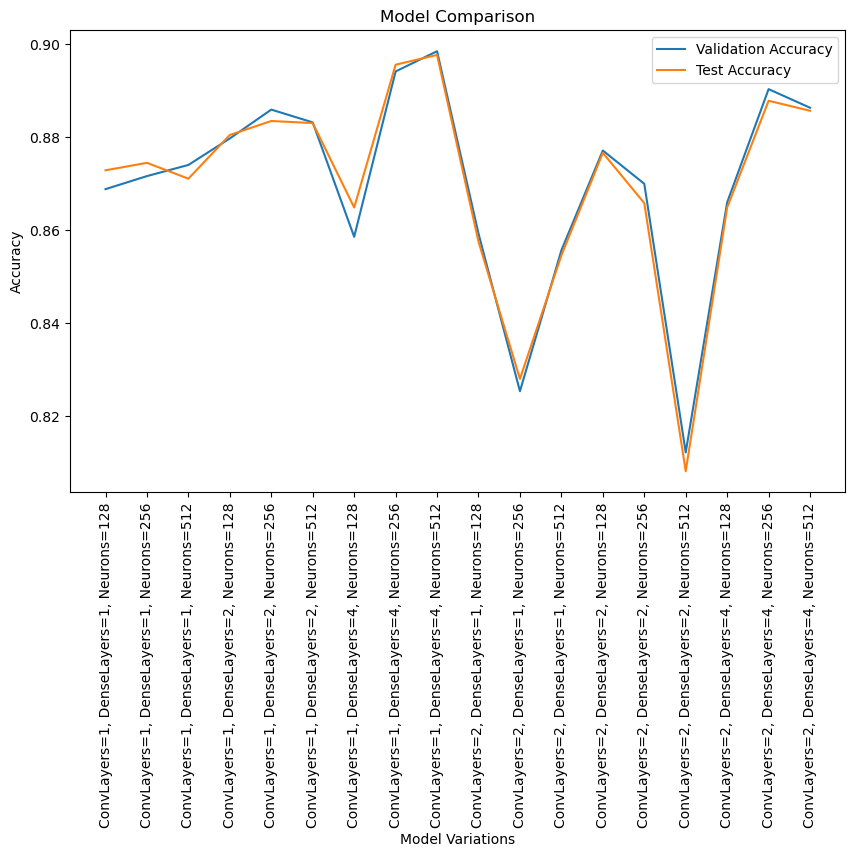

In [ ]:
# Plot the results with labels
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(labels, val_accuracies, label='Validation Accuracy')
ax.plot(labels, test_accuracies, label='Test Accuracy')
ax.set_xlabel('Model Variations')
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [ ]:
np.max(test_accuracies)

0.8977000117301941

In [ ]:
# Define the range of L2 regularization strengths to experiment with
l2_strengths = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

# Initialize arrays to store accuracy results
val_accuracies = []
test_accuracies = []

for l2_strength in l2_strengths:
    # Create a model with the specified L2 regularization strength
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(l2_strength)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on your data (replace with your data loading code)
    model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=validation_split)

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(x_val,y_val)
    val_accuracies.append(val_accuracy)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(x_test,y_test)
    test_accuracies.append(test_accuracy)

    # Create a label for this combination of hyperparameters
    label = f"ConvLayers={num_conv_layers}, DenseLayers={num_dense_layers}, Neurons={num_neurons}"
    labels.append(label)

Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 2.5166 - accuracy: 0.8131 - val_loss: 1.2733 - val_accuracy: 0.8756
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.9665 - accuracy: 0.8791
Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 8.2492 - accuracy: 0.8155 - val_loss: 3.9239 - val_accuracy: 0.8639
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 1.8467 - accuracy: 0.8813
Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 24.5136 - accuracy: 0.7645 - val_loss: 3.1227 - val_accuracy: 0.8002
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.8688 - accuracy: 0.7639
Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 44.6695 - accuracy: 0.7382 - val_loss: 2.5160 - val_accuracy: 0.7458
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.7414 - accuracy: 0.7869
Epoch 1/2
1000/1000 [=========

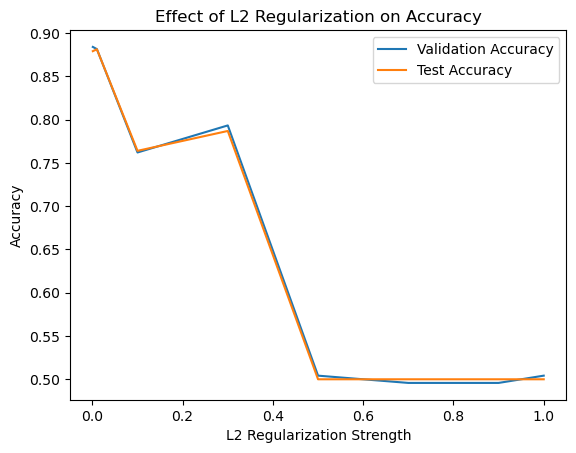

In [ ]:
# Plot the results
plt.plot(l2_strengths, val_accuracies, label='Validation Accuracy')
plt.plot(l2_strengths, test_accuracies, label='Test Accuracy')
plt.xlabel('L2 Regularization Strength')
plt.ylabel('Accuracy')
plt.title('Effect of L2 Regularization on Accuracy')
plt.legend()
plt.show()

In [ ]:
# Define the range of dropout rates to experiment with
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize arrays to store accuracy results
validation_accuracies = []
test_accuracies = []

for dropout_rate in dropout_rates:
    # Create a model with the specified dropout rate
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add Dropout with the specified rate
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model (assuming you have already split your data into training, validation, and test sets)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    # Evaluate the model on the validation set
    validation_loss, validation_accuracy = model.evaluate(x_val, y_val)
    validation_accuracies.append(validation_accuracy)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    test_accuracies.append(test_accuracy)

Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 1.1440 - accuracy: 0.8152 - val_loss: 0.3432 - val_accuracy: 0.8634
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.2844 - accuracy: 0.8832
Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 1.3572 - accuracy: 0.8119 - val_loss: 0.2681 - val_accuracy: 0.8890
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.2511 - accuracy: 0.8953
Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 1.1521 - accuracy: 0.8135 - val_loss: 0.2898 - val_accuracy: 0.8775
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.2573 - accuracy: 0.8934
Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 1.2408 - accuracy: 0.8136 - val_loss: 0.2804 - val_accuracy: 0.8862
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.2810 - accuracy: 0.8824
Epoch 1/2
1000/1000 [===========

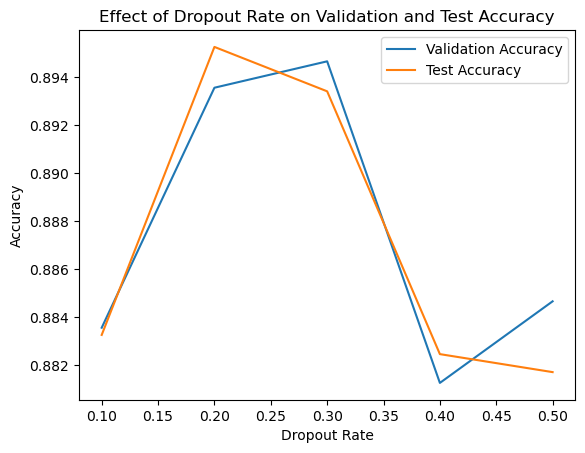

In [ ]:
# Plot the results
plt.plot(dropout_rates, validation_accuracies, label='Validation Accuracy')
plt.plot(dropout_rates, test_accuracies, label='Test Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.title('Effect of Dropout Rate on Validation and Test Accuracy')
plt.legend()
plt.show()

In [ ]:
# Trying with optimal hyperparameters for L2 regularization and Dropout

model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add dense layers
for _ in range(4):
    model.add(Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001)))

model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train,epochs=10,batch_size=batch_size,validation_split=validation_split)

Epoch 1/10
1000/1000 [==============================] - 10s 8ms/step - loss: 2.2375 - accuracy: 0.8221 - val_loss: 1.2154 - val_accuracy: 0.8805
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0657 - accuracy: 0.8813 - val_loss: 0.9330 - val_accuracy: 0.8798
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8163 - accuracy: 0.8929 - val_loss: 0.7230 - val_accuracy: 0.9019
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6519 - accuracy: 0.8989 - val_loss: 0.5962 - val_accuracy: 0.8952
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5297 - accuracy: 0.9037 - val_loss: 0.5011 - val_accuracy: 0.8920
Epoch 6/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4402 - accuracy: 0.9052 - val_loss: 0.4587 - val_accuracy: 0.8808
Epoch 7/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3697 - accuracy: 0.9111 - val_loss: 0.3648 - val_accuracy

In [ ]:
model.evaluate(x_val, y_val)

625/625 [==============================] - 3s 4ms/step - loss: 0.3194 - accuracy: 0.9035


[0.31935518980026245, 0.9034500122070312]

In [ ]:
model.evaluate(x_test,y_test)

625/625 [==============================] - 3s 4ms/step - loss: 0.3224 - accuracy: 0.9020


[0.3223610818386078, 0.9019500017166138]